In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import poisson
from scipy.stats import skellam

In [2]:
crime_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso/integer_valued_ts/crime_480_data.xlsx')
# crime_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/z-values-series/813_crimes.xlsx')
# "C:\Users\michelj8\Documents\GitHub\z-values-series\crime_230_data.xlsx"
# "C:\Users\michelj8\Documents\GitHub\expo_smooth_lasso\integer_valued_ts\crime_888_data.xlsx"

In [3]:
crime_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,191506964,2019-02-25,2019-02-25,2325,15,N Hollywood,1557,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,5000 CARTWRIGHT AV,NaN,34.1613,-118.3637
1,190128566,2019-12-05,2019-12-04,2230,1,Central,152,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,7TH,FLOWER ST,34.0487,-118.2588
2,190615415,2019-07-13,2019-07-13,1830,6,Hollywood,666,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,6300 W SUNSET BL,NaN,34.0980,-118.3267
3,190606178,2019-01-30,2019-01-01,1050,6,Hollywood,669,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,5300 LEXINGTON AV,NaN,34.0930,-118.3046
4,190104755,2019-01-12,2019-01-09,2200,1,Central,158,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,800 E 6TH ST,NaN,34.0408,-118.2428


In [4]:
crime_data['Crm Cd Desc'].unique()

array(['BIKE - STOLEN'], dtype=object)

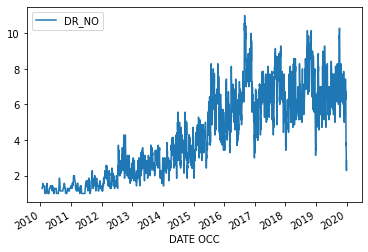

In [5]:
crime_data.groupby(['DATE OCC']).count()[['DR_NO']].rolling(window = 7).mean().plot()

In [6]:
ts_df = crime_data.groupby(['DATE OCC']).count()[['DR_NO']].reset_index()
ts_df['year-month'] = ts_df['DATE OCC'].apply(lambda s: str(s)[0:7])

ts_df = ts_df.groupby('year-month').sum()
ts_df.columns = ['Y']

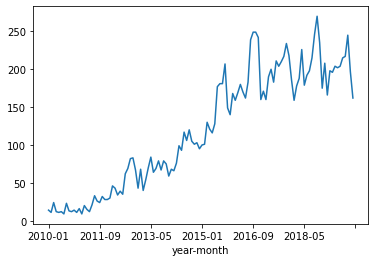

In [7]:
ts_df['Y'].plot()

In [8]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_df, (1,0)).fit()
model.params

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      109.783877
ar.L1.Y      0.964032
dtype: float64

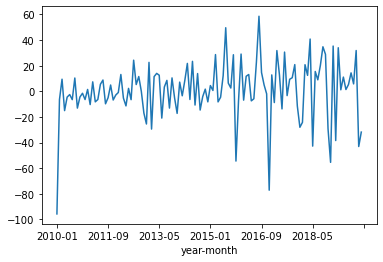

In [9]:
model.resid.plot()

# Add in transformations and plots

In [10]:
ts_df['delta'] = ts_df['Y'].diff(1)
ts_df['abs_delta'] = np.abs(ts_df['delta'])

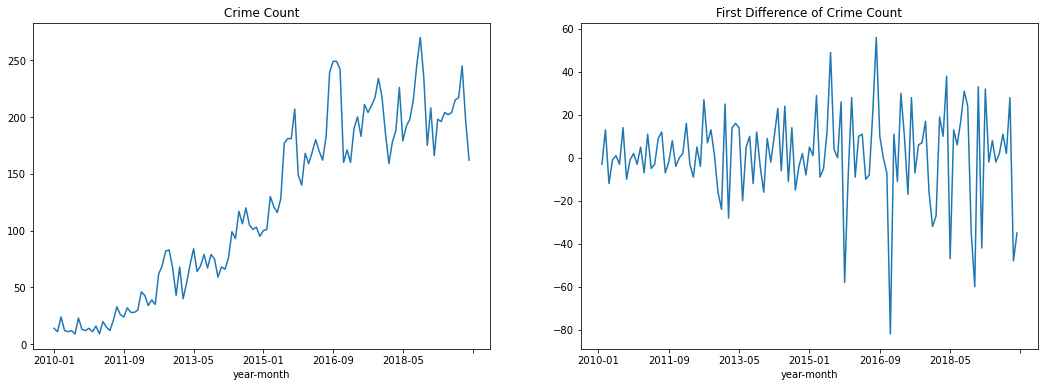

In [11]:
fig, ax  = plt.subplots(1,2, figsize = (18,6))

ts_df['Y'].plot(ax = ax[0], title = 'Crime Count')
ts_df['delta'].plot(ax = ax[1], title = 'First Difference of Crime Count')

In [12]:
ts_df['delta'].describe()

count    119.000000
mean       1.243697
std       20.946650
min      -82.000000
25%       -7.500000
50%        2.000000
75%       12.500000
max       56.000000
Name: delta, dtype: float64

In [13]:
rolling_summary_df = pd.DataFrame(columns = ['mean','var','abs','sign'])

rolling_summary_df['mean'] = ts_df['delta'].rolling(window = 12).mean()
rolling_summary_df['var'] = np.square(ts_df['delta'].rolling(window = 12).std())
rolling_summary_df['abs'] = np.abs(ts_df['delta']).rolling(window = 12).mean()
rolling_summary_df['sign'] = np.sign(ts_df['delta']).rolling(window = 12).mean()

C:\Users\michelj8\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


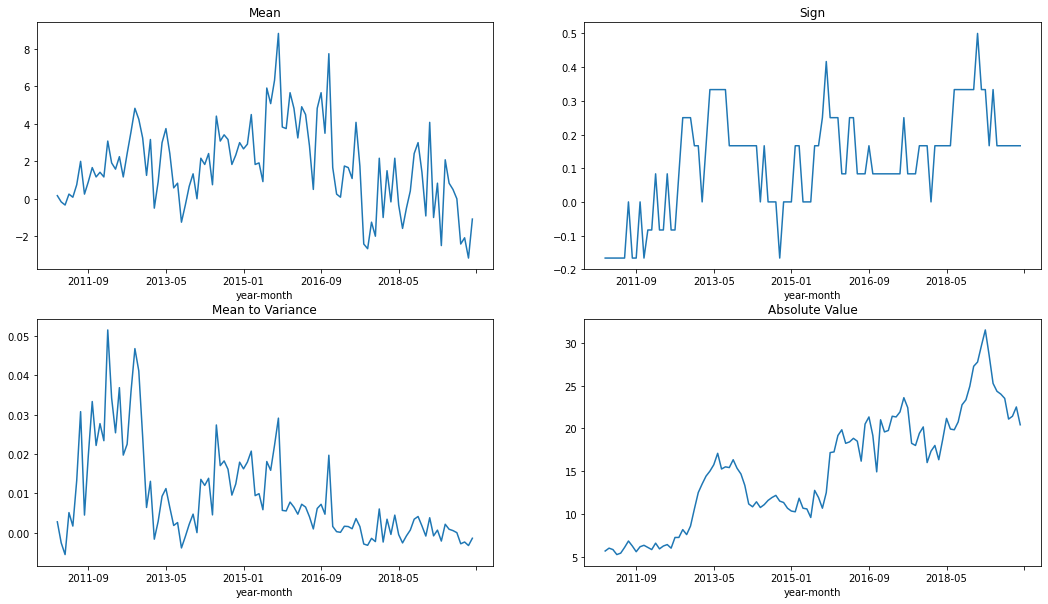

In [14]:
fig, ax = plt.subplots(2,2, figsize = (18,10))

rolling_summary_df['mean'].plot(ax = ax[0][0], title = 'Mean')
# rolling_summary_df['var'].plot(ax = ax[1][0], title = 'Variance')
(rolling_summary_df['mean']/rolling_summary_df['var']).plot(ax = ax[1][0], title = 'Mean to Variance')
rolling_summary_df['sign'].plot(ax = ax[0][1], title = 'Sign')
rolling_summary_df['abs'].plot(ax = ax[1][1], title = 'Absolute Value')

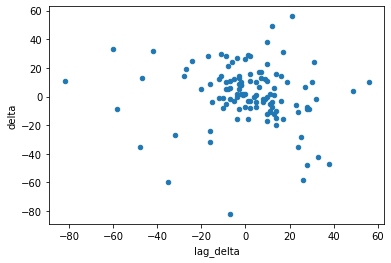

In [15]:
ts_df['lag_delta'] = ts_df['delta'].shift(1)
ts_df['abs_delta'] = np.abs(ts_df['delta'])
ts_df.plot.scatter(x='lag_delta',y='delta')

In [16]:
from statsmodels.tsa.stattools import acf, pacf
acf(ts_df['delta'].dropna())

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        , -0.12523434, -0.02143841, -0.14209078, -0.22022475,
       -0.03075918,  0.05838239,  0.17418154, -0.23826606, -0.08016097,
       -0.08057162,  0.07644729,  0.27656177,  0.27822527, -0.10010017,
       -0.00982147, -0.23516118, -0.05011073,  0.07243819,  0.03689744,
       -0.08199421, -0.13293368, -0.08175125,  0.07767422,  0.29060687,
       -0.03195789,  0.16375494, -0.07587524, -0.13703773, -0.02391245,
        0.0119034 ,  0.00581892, -0.12545412,  0.03851128, -0.14494272,
        0.00146153,  0.32193605,  0.05639019, -0.04097233,  0.07299143,
       -0.20617797])

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const          1.282236
ar.L1.delta   -0.127476
dtype: float64


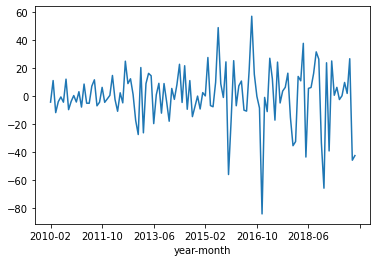

In [17]:
model = ARMA(ts_df['delta'].dropna(), (1,0)).fit()
print(model.params)
model.resid.plot()

const              15.065196
ar.L1.abs_delta     0.259566
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


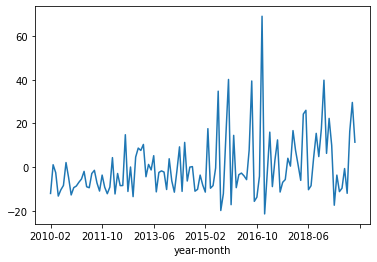

In [18]:
model = ARMA(ts_df['abs_delta'].dropna(), (1,0)).fit()
print(model.params)
model.resid.plot()

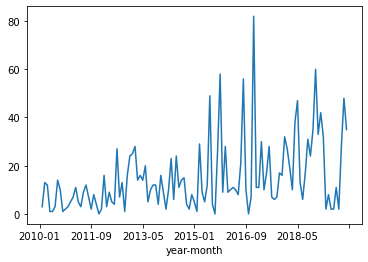

In [19]:
ts_df['abs_delta'].plot()

In [20]:
ts_df['delta_lag'] = ts_df['delta'].shift(1)

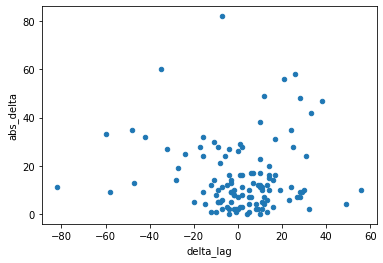

In [21]:
ts_df.plot.scatter(x='delta_lag' ,y='abs_delta')

# Estimation

## Time trend AR-Poisson

In [22]:
def tt_ar_pois(gamma,omega,alpha,beta,ts):
    sample_size = len(ts)
    ll_value = 0
    mean_est = omega
    inf_status = 0
    
    for r in range(1,sample_size):
        new_y = ts[r]
#         ll_value = -1*np.log( poisson.pmf(new_y ,mean_est) )
        obs_ll_value = poisson.pmf(new_y,mean_est)
        ll_value = ll_value + obs_ll_value
        mean_est = gamma*r + omega + alpha*new_y + beta*mean_est
        
        if obs_ll_value < -100:
            inf_status =1
            
    if inf_status == 1:
        return 10000
    
    if inf_status == 0:
        return -ll_value

In [23]:
def tt_ar_pois_filter(gamma,omega,alpha,beta,ts):
    sample_size = len(ts)
    mean_est = [omega]
    
    for r in range(1, sample_size):
        new_y = ts[r]
        new_mean_est = gamma*r + omega + alpha*new_y + beta*mean_est[-1]
        mean_est.append(new_mean_est)
        
    filter_df = pd.DataFrame({'Y':ts,'mean_est':mean_est})
    filter_df['mean_est'] = filter_df['mean_est'].shift(1)
    filter_df = filter_df.dropna()
    return filter_df

In [24]:
Y = ts_df['Y'].dropna()

initial_guess = [1,1,.1,.2]
guess = initial_guess.copy()

for iteration in range(0,30):
    res_g = minimize_scalar( lambda g_hat : tt_ar_pois(g_hat, guess[1], guess[2], guess[3],Y ), bounds = (.01,3), method = 'bounded')
    guess[0] = res_g.x

    res_o = minimize_scalar( lambda o_hat : tt_ar_pois(guess[0], o_hat, guess[2], guess[3],Y ), bounds = (.01,3),  method = 'bounded')
    guess[1] = res_o.x

    res_a = minimize_scalar( lambda a_hat : tt_ar_pois(guess[0], guess[1], a_hat, guess[2],Y ), bounds = (0,1), method = 'bounded')
    guess[2] = res_a.x

    res_b = minimize_scalar( lambda b_hat : tt_ar_pois(guess[0], guess[1], guess[2], b_hat,Y ), bounds = (0, 1) , method = 'bounded')
    guess[3] = res_b.x

guess

[0.9314036685297176,
 0.01000347428866272,
 0.18795447943146318,
 0.305783408678613]

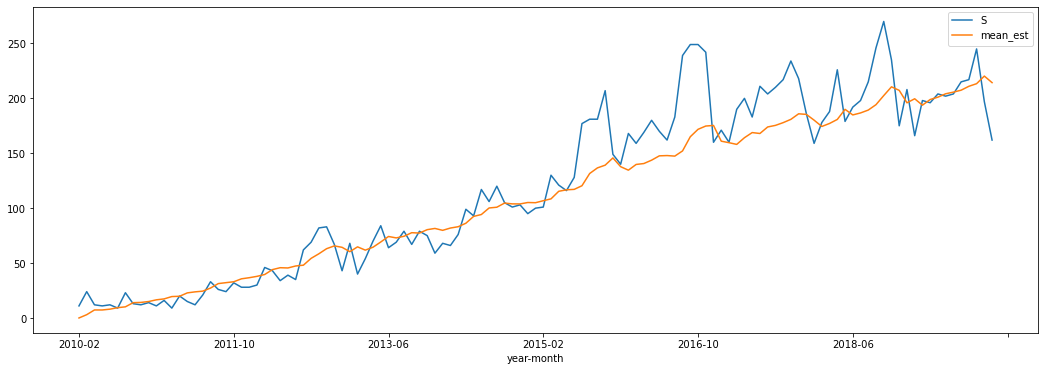

In [25]:
gamma,omega,alpha,beta  = guess
mle_df = tt_ar_pois_filter(gamma,omega,alpha,beta,Y)

fig, ax = plt.subplots(figsize = (18,6))
mle_df.plot(ax =ax)
ax.legend(['S','mean_est'])

0.3277310924369748

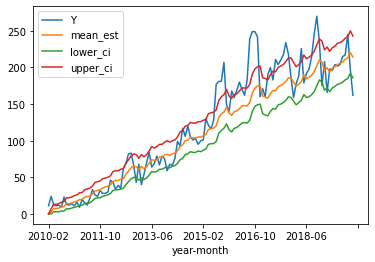

In [26]:
ci_alpha = .95

for index in mle_df.index:
    ci = poisson.interval(ci_alpha, mle_df.loc[index,'mean_est'])
    mle_df.loc[index,'lower_ci'] = ci[0]
    mle_df.loc[index,'upper_ci'] = ci[1]
    
mle_df.plot()
len(mle_df.query('Y < lower_ci | Y > upper_ci'))/len(mle_df)

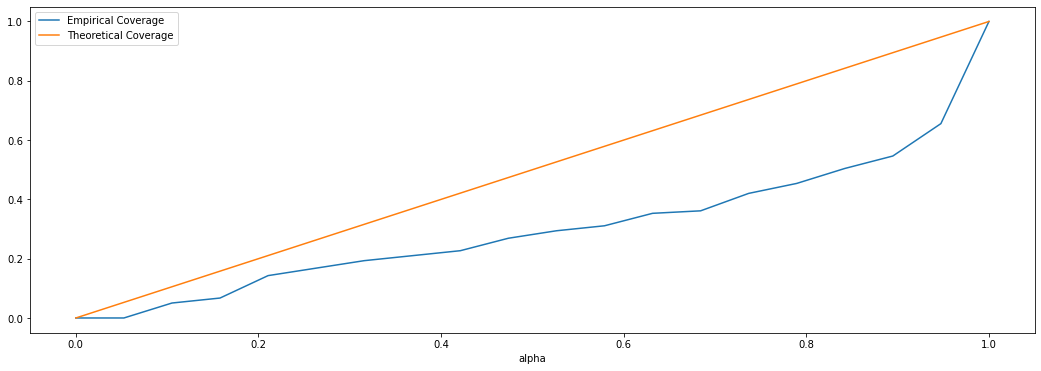

In [27]:
ci_cover_df = pd.DataFrame(columns = ['alpha','actual_coverage']).set_index('alpha')
grid_size = 20
fig, ax = plt.subplots(figsize = (18,6))


for ci_alpha in np.linspace(0,1,grid_size):
    for index in mle_df.index:
        ci = poisson.interval(ci_alpha, mle_df.loc[index,'mean_est'])
        mle_df.loc[index,'lower_ci'] = ci[0]
        mle_df.loc[index,'upper_ci'] = ci[1]
        
    ci_cover_df.loc[ci_alpha, 'actual_coverage'] = len(mle_df.query('Y > lower_ci & Y < upper_ci'))/len(mle_df)
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
ci_cover_df.plot(ax = ax)
ax.legend(['Empirical Coverage','Theoretical Coverage'])

## Skellam Estimation

In [28]:
def censor(val,lower_bound, upper_bound):
    return min( max(val,lower_bound), upper_bound)

In [29]:
def skellam_ar(o,a,b,r,ts):
#     sample_size = len(ts)
#     r_factor = .5*(3*r-1)/(r+1)
    
#     ll_value = 0
#     mean_est = ts[0]
    
#     inf_status = 0
    
#     for r in range(1,sample_size):
#         state_var = abs(mean_est) * (r_factor + .5*np.sign(mean_est)*np.array([1,-1]))
#         new_y = censor(ts[r], -20,20)
        
#         obs_ll_value = np.log( skellam(state_var[0],state_var[1]).pmf(new_y) )
#         ll_value = ll_value + obs_ll_value
#         mean_est =  o + a*new_y + b*mean_est
        
#         if obs_ll_value < -200:
#             inf_status =1
            
#     if inf_status == 1:
#         return 10000
    
#     if inf_status == 0:
#         return -ll_value

    sample_size = len(ts)
    
    ll_value = 0
    mean_est = ts[0]
    
    inf_status = 0
    
    for r in range(1,sample_size):
        state_var = abs(mean_est/2.0) * ((r/2.0) + np.sign(mean_est)*np.array([1,-1]))
        new_y = censor(ts[r], -25,25)
        
        obs_ll_value = np.log( skellam(state_var[0],state_var[1]).pmf(new_y) )
        ll_value = ll_value + obs_ll_value
        mean_est =  o + a*new_y + b*mean_est
        
        if obs_ll_value < -200:
            inf_status =1
            
    if inf_status == 1:
        return 10000
    
    if inf_status == 0:
        return -ll_value

In [30]:
def skellam_ar_ols(o,a,b,r,ts):
    sample_size = len(ts)
    
    ll_value = 0
    mean_est = ts[0]
        
    for r in range(1,sample_size):
        new_y = censor(ts[r],-20,20)
        
        obs_ll_value = np.square(ts[r]-mean_est)
        
        ll_value = ll_value + obs_ll_value
        mean_est =  o + a*new_y + b*mean_est
        
            
    return ll_value

In [31]:
def skellam_filter(c,a,b,r,ts):
    sample_size = len(ts)

    mu_est = [ts[0]]
    for time in range(1,sample_size):
        new_mu_est = c+a*ts[time] + b*mu_est[-1]
        mu_est.append(new_mu_est)
    
    filter_df = pd.DataFrame({'obs':ts, 'mu_est':mu_est})
    filter_df['mu_est'] = filter_df['mu_est'].shift(1)
    filter_df = filter_df.dropna()
    
    filter_df['state1'] = filter_df['mu_est'].apply(lambda s: abs(s/2)*( (r/2.0) + np.sign(s)) )
    filter_df['state2'] =filter_df['mu_est'].apply(lambda s: abs(s/2)*( (r/2.0) - np.sign(s)) )
    
    return filter_df

In [32]:
delta_series = ts_df['delta'].dropna()

initial_guess = [0.5,.5,.2, 100.0]
guess = initial_guess.copy()

for iteration in range(0,5):
    res_o = minimize_scalar( lambda o_hat : skellam_ar(o_hat, guess[1], guess[2], guess[3], delta_series ), bounds = (-2,2),  method = 'bounded')
    guess[0] = res_o.x

    res_a = minimize_scalar( lambda a_hat : skellam_ar(guess[0],a_hat, guess[2], guess[3],  delta_series ), bounds = (0,1-guess[2]), method = 'bounded')
    guess[1] = res_a.x

    res_b = minimize_scalar( lambda b_hat : skellam_ar(guess[0], guess[1], b_hat, guess[3], delta_series ), bounds = (0, 1-guess[1]) , method = 'bounded')
    guess[2] = res_b.x
    
#     res_r = minimize_scalar( lambda r_hat : skellam_ar(guess[0], guess[1], guess[2], r_hat , Y ), bounds = (1.5,5), method = 'bounded')
#     guess[3] = res_r.x


guess

[-0.4721359549995796, 0.2764064236422914, 0.2763881521275523, 100.0]

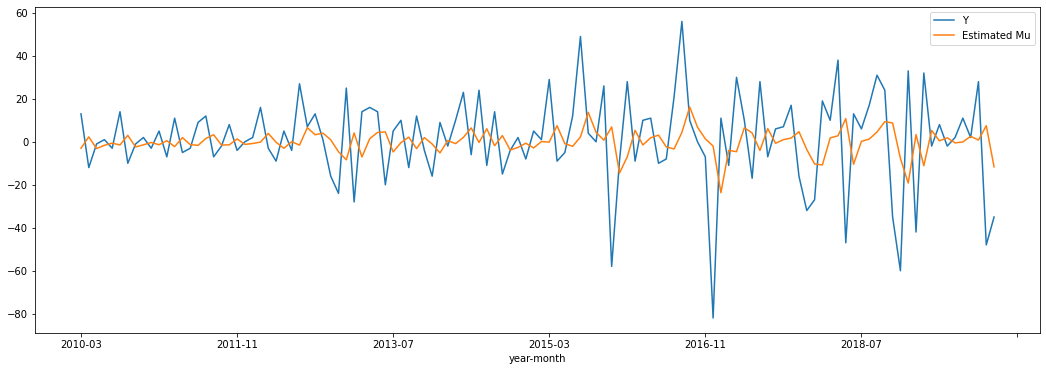

In [33]:
# c,a,b,r = initial_guess
c,a,b,r = guess
# r = 150.0
# c,a,b,r = [1.5,.5,.2, 2.0]

fig, ax = plt.subplots(figsize = (18,6))

mle_df = skellam_filter(c,a,b,r,delta_series) 
mle_df[['obs','mu_est']].plot(ax = ax)
ax.legend(['Y','Estimated Mu'])

In [34]:
mle_df.tail()

,obs,mu_est,state1,state2
year-month,,,,
2019-08,11.0,-0.060530,1.482978,1.543508
2019-09,2.0,2.551605,65.065928,62.514323
2019-10,28.0,0.785910,20.040712,19.254802
2019-11,-48.0,7.484460,190.853735,183.369275
2019-12,-35.0,-11.671028,285.940190,297.611218


0.22033898305084745

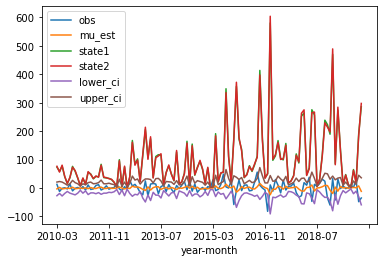

In [35]:
ci_alpha = .95

for index in mle_df.index:
    ci = skellam(mle_df.loc[index, 'state1'], mle_df.loc[index,'state2']).interval(ci_alpha)
    mle_df.loc[index,'lower_ci'] = ci[0]
    mle_df.loc[index,'upper_ci'] = ci[1]
    
mle_df.plot()
len(mle_df.query('obs < lower_ci | obs > upper_ci'))/len(mle_df)

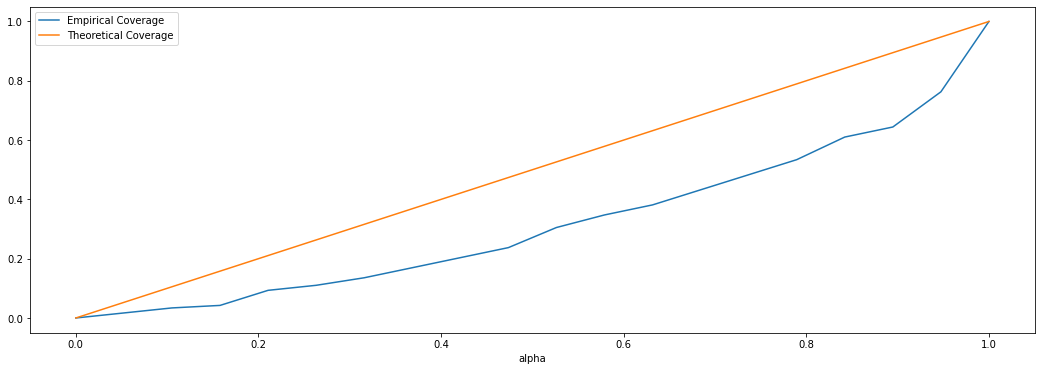

In [36]:
ci_cover_df = pd.DataFrame(columns = ['alpha','actual_coverage']).set_index('alpha')
grid_size = 20
fig, ax = plt.subplots(figsize = (18,6))


for ci_alpha in np.linspace(0,1,grid_size):
    for index in mle_df.index:
        ci = skellam(mle_df.loc[index, 'state1'], mle_df.loc[index,'state2']).interval(ci_alpha)
        mle_df.loc[index,'lower_ci'] = ci[0]
        mle_df.loc[index,'upper_ci'] = ci[1]
        
    ci_cover_df.loc[ci_alpha, 'actual_coverage'] = len(mle_df.query('obs > lower_ci & obs < upper_ci'))/len(mle_df)
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
ci_cover_df.plot(ax = ax)
ax.legend(['Empirical Coverage','Theoretical Coverage'])